# RETICOLO con passo 300

$d\sin\theta = n\lambda$ con n numero intero

E' stata utilizzata una lampada al sodio

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys
from jax import grad
from jax import numpy as jnp

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from giopy import Interpolazione, final_val

sys.path.append(dir_path)
from spectra_reppresentation import draw_spectrum

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'reticolo_300.csv'
fr = pd.read_csv(FILE)
fr = fr.set_index('colore')

In [2]:
def formatter(data) -> dict: # ritorna il valore degli angoli date le righe del dataframe
    keys = ['n1','n2','n3','-n1','-n2','-n3']
    d = {}
    for i in range(0,len(data),2): # i = gradi, i+1 = primi
        d[keys[int(i/2)]] = np.float64(data[i] + data[i+1]/60)
    return d

giallo = formatter(fr.loc['GIALLO']) # come argomento passo una la riga
verde = formatter(fr.loc['VERDE'])
acqua = formatter(fr.loc['ACQUA'])

λ = {'GIALLO':590,'VERDE':569,'ACQUA':498} # Na Sodio
sigmaθ = np.radians(0.18)  # deg ricavato in errori

$d = \frac{n\lambda}{\sin\theta}$

In [3]:
def passo(n,λ,θ): # n = ordini, λ = lunghezza d'onda, θ = angoli
    return n*λ/jnp.abs(jnp.sin(jnp.radians(θ)))

def sigma_passo(n,λ,θ):
    dddθ = np.array([grad(passo,argnums=2)(i,λ,g) for i,g in zip(n,θ)])
    return jnp.abs(dddθ * sigmaθ)

m = np.array([1,2,3,1,2,3],dtype=np.int16) # ordini

d_giallo = passo(m,λ['GIALLO'],np.array(list(giallo.values()))) # nm
sigmad_giallo = sigma_passo(m,λ['GIALLO'],np.array(list(giallo.values()))) # nm

d_verde = passo(m,λ['VERDE'],np.array(list(verde.values()))) # nm
sigmad_verde = sigma_passo(m,λ['VERDE'],np.array(list(verde.values()))) # nm

d_acqua = passo(m,λ['ACQUA'],np.array(list(acqua.values()))) # nm
sigmad_acqua = sigma_passo(m,λ['ACQUA'],np.array(list(acqua.values()))) # nm

d = np.concatenate((d_giallo,d_verde,d_acqua)) * 10**-9 # m
sigmad = np.concatenate((sigmad_giallo,sigmad_verde,sigmad_acqua)) * 10**-9 # m

dm = np.mean(d)
dstd = np.std(d)

print('Passo reticoli: ',final_val(dm,dstd,2,-6,'m'))
print('attesi 1/300 reticoli/mm',np.round(1/300 * 1000,2))

Passo reticoli:  (3.29 ± 0.01)e-6 m
attesi 1/300 reticoli/mm 3.33


# DETERMINAZIONE GAS INCOGNITO:

ora $d$ è noto (determinato nell'esperienza precedente), patendo da un gas ignoto bisogna determinare l'elemento

$d\sin\theta \cdot\frac{1}{n} = \lambda$

In [4]:
FILE = dir_path + '/data/' + 'reticolo_300_ignoto.csv'
fr = pd.read_csv(FILE)
fr = fr.set_index('colore')

In [5]:
giallo = formatter(fr.loc['GIALLO'][:6]) # come argomento passo una la riga
verde = formatter(fr.loc['VERDE'][:6])
acqua = formatter(fr.loc['ACQUA'][:6])
blu = formatter(fr.loc['BLU'][:6])

m = np.array([1,2,3],dtype=np.int16) # ordini
d,sigmad = dm * 10**9,dstd* 10**9 # rinomino variabili e metto in nm
#sigma teta

In [6]:
def lambda_val(n,θ,d): # n = ordini, θ = angoli, d = passo
    return jnp.abs(d*jnp.sin(jnp.radians(θ)) / n)

def sigma_lambda(n,θ,d):
    dddd = np.array([grad(lambda_val,argnums=2)(i,g,d) for i,g in zip(n,θ)])
    dddteta = np.array([grad(lambda_val,argnums=1)(i,g,d) for i,g in zip(n,θ)])
    return jnp.sqrt(dddd**2 * sigmad**2 + dddteta**2 * sigmaθ**2)

λ_giallo = lambda_val(m,np.array(list(giallo.values())),d) # nm
sigma_lambda_giallo = sigma_lambda(m,np.array(list(giallo.values())),d) # nm
giallom = np.average(λ_giallo,weights=1/sigma_lambda_giallo**2)
sigma_giallom = 1/np.sqrt(np.sum(1/sigma_lambda_giallo**2))

λ_verde = lambda_val(m,np.array(list(verde.values())),d) # nm
sigma_lambda_verde = sigma_lambda(m,np.array(list(verde.values())),d) # nm
verdem = np.average(λ_verde,weights=1/sigma_lambda_verde**2)
sigma_verdem = 1/np.sqrt(np.sum(1/sigma_lambda_verde**2))

λ_acqua = lambda_val(m,np.array(list(acqua.values())),d) # nm
sigma_lambda_acqua = sigma_lambda(m,np.array(list(acqua.values())),d) # nm
acquam = np.average(λ_acqua,weights=1/sigma_lambda_acqua**2)
sigma_acquam = 1/np.sqrt(np.sum(1/sigma_lambda_acqua**2))

λ_blu = lambda_val(m,np.array(list(blu.values())),d) # nm
sigma_lambda_blu = sigma_lambda(m,np.array(list(blu.values())),d) # nm
blum = np.average(λ_blu,weights=1/sigma_lambda_blu**2)
sigma_blum = 1/np.sqrt(np.sum(1/sigma_lambda_blu**2))

λ_incognito = np.array([giallom,verdem,acquam,blum])
sigmaλ_incognito = np.array([sigma_giallom,sigma_verdem,sigma_acquam,sigma_blum])

print('lambda incognito:', λ_incognito)
print('sigma_lambda incognito:', sigmaλ_incognito)

lambda incognito: [580.54395745 549.79749542 497.58639126 438.63259515]
sigma_lambda incognito: [1.03340708 0.97892082 0.88646602 0.78212866]


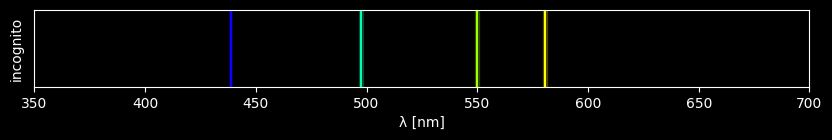

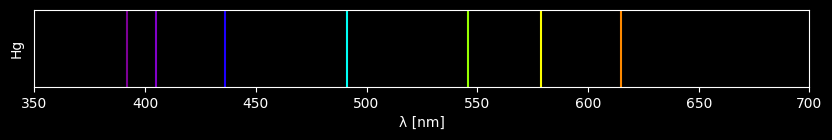

In [7]:
FILE = dir_path + '/data/' + 'LINEE_SPETTRO_Hg.csv'
fr = pd.read_csv(FILE)
fr.set_index('colore',inplace=True)
fr = fr.sort_values('λ (nm)',ascending=False)

# ESCLUDO I VIOLA IN QUANTO DIFFICILMENTE VISIBLI

λ_Hg = np.array(fr['λ (nm)'])#[:-1] # * (10**-9) # nm
sigmaλ_Hg = np.array(fr['sigmaλ'])#[:-1] # * (10**-9)

draw_spectrum(λ_incognito,sigmaλ_incognito,ytitle='incognito')
draw_spectrum(λ_Hg,ytitle='Hg')